In [10]:
import pandas as pd
from datetime import datetime


In [2]:
# loading data
import os

pwd = os.getcwd()

def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
dataset = pd.read_csv(pwd + '\pollution.csv', parse_dates=[['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.head(10)

C:\Users\ivane\AppData\Local\Temp\ipykernel_21212\1060378458.py:8: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  dataset = pd.read_csv(pwd + '\pollution.csv', parse_dates=[['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
C:\Users\ivane\AppData\Local\Temp\ipykernel_21212\1060378458.py:8: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  dataset = pd.read_csv(pwd + '\pollution.csv', parse_dates=[['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)


,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
year_month_day_hour,,,,,,,,,
2010-01-01 00:00:00,1,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,3,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,4,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,5,NaN,-20,-12.0,1018.0,NW,12.97,0,0
2010-01-01 05:00:00,6,NaN,-19,-10.0,1017.0,NW,16.10,0,0
2010-01-01 06:00:00,7,NaN,-19,-9.0,1017.0,NW,19.23,0,0
2010-01-01 07:00:00,8,NaN,-19,-9.0,1017.0,NW,21.02,0,0
2010-01-01 08:00:00,9,NaN,-19,-9.0,1017.0,NW,24.15,0,0


In [4]:
dataset.drop('No', axis=1, inplace=True)

In [5]:
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'

In [6]:
# marking all NA values with 0
dataset['pollution'].fillna(0, inplace=True)

C:\Users\ivane\AppData\Local\Temp\ipykernel_21212\4281727429.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset['pollution'].fillna(0, inplace=True)


In [7]:
# dropping first 24hrs
dataset = dataset[24:]
dataset.head(5)

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [8]:
dataset.to_csv(pwd + '\pollution_clean.csv')

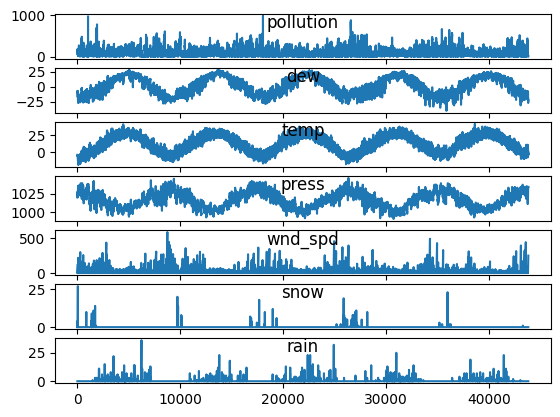

In [9]:
from matplotlib import pyplot
# load dataset
dataset = pd.read_csv(pwd + '\pollution_clean.csv', header=0, index_col=0)
values = dataset.values

# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1

# plot each column
pyplot.figure()

for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='center')
    i += 1
pyplot.show()

# LSTM Prep and Implementation

The first step is to prepare the pollution dataset for the LSTM.

This involves framing the dataset as a supervised learning problem and normalizing the input variables.

We will frame the supervised learning problem as predicting the pollution at the current hour (t) given the pollution measurement and weather conditions at the prior time step.

In [11]:
# prepare data for lstm
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# load dataset
dataset = pd.read_csv('pollution_clean.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  


In [12]:
# define and fit model

values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


Epoch 1/50
122/122 - 3s - loss: 0.0618 - val_loss: 0.0597 - 3s/epoch - 25ms/step
Epoch 2/50
122/122 - 1s - loss: 0.0441 - val_loss: 0.0621 - 775ms/epoch - 6ms/step
Epoch 3/50
122/122 - 1s - loss: 0.0271 - val_loss: 0.0536 - 799ms/epoch - 7ms/step
Epoch 4/50
122/122 - 1s - loss: 0.0181 - val_loss: 0.0426 - 706ms/epoch - 6ms/step
Epoch 5/50
122/122 - 1s - loss: 0.0159 - val_loss: 0.0291 - 732ms/epoch - 6ms/step
Epoch 6/50
122/122 - 1s - loss: 0.0151 - val_loss: 0.0200 - 720ms/epoch - 6ms/step
Epoch 7/50
122/122 - 1s - loss: 0.0149 - val_loss: 0.0181 - 723ms/epoch - 6ms/step
Epoch 8/50
122/122 - 1s - loss: 0.0148 - val_loss: 0.0169 - 721ms/epoch - 6ms/step
Epoch 9/50
122/122 - 1s - loss: 0.0147 - val_loss: 0.0159 - 723ms/epoch - 6ms/step
Epoch 10/50
122/122 - 1s - loss: 0.0147 - val_loss: 0.0153 - 738ms/epoch - 6ms/step
Epoch 11/50
122/122 - 1s - loss: 0.0145 - val_loss: 0.0148 - 765ms/epoch - 6ms/step
Epoch 12/50
122/122 - 1s - loss: 0.0146 - val_loss: 0.0146 - 773ms/epoch - 6ms/step
Epo

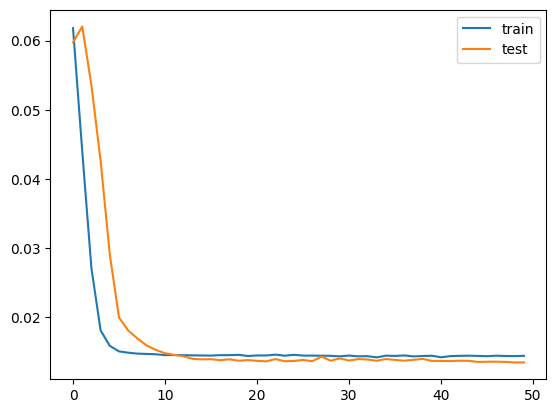

In [13]:
# design network
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

pyplot.show()

In [14]:
import numpy as np
from sklearn.metrics import mean_squared_error
# evaluate model
#make prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))

inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)

inv_y = inv_y[:,0]
# calculate RMSE

rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

1095/1095 [==============================] - 2s 1ms/step
Test RMSE: 26.464
